In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import datasets



# **Пример классификации на примере датасета Титаник**

In [4]:
df = pd.read_csv('./data/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Уборка в данных + feature engineering**

In [5]:
df['Family_Size'] = df['SibSp'] + df['Parch'] + 1 # создаем новую переменную на основе двух других
df = df[['Pclass','Sex','Fare','Age','Family_Size', 'Survived']]

df = pd.get_dummies(df, columns=['Sex','Pclass'], dtype='int', drop_first=True) # создаем дамми-переменные для категориальных признаков

df['Age'] = df['Age'].fillna(round(df['Age'].mean(), 0))
df

,Fare,Age,Family_Size,Survived,Sex_male,Pclass_2,Pclass_3
0,7.2500,22.0,2,0,1,0,1
1,71.2833,38.0,2,1,0,0,0
2,7.9250,26.0,1,1,0,0,1
3,53.1000,35.0,2,1,0,0,0
4,8.0500,35.0,1,0,1,0,1
...,...,...,...,...,...,...,...
886,13.0000,27.0,1,0,1,1,0
887,30.0000,19.0,1,1,0,0,0
888,23.4500,30.0,4,0,0,0,1
889,30.0000,26.0,1,1,1,0,0


In [6]:
features = df.columns
features = features.drop('Survived')
features

Index(['Fare', 'Age', 'Family_Size', 'Sex_male', 'Pclass_2', 'Pclass_3'], dtype='object')

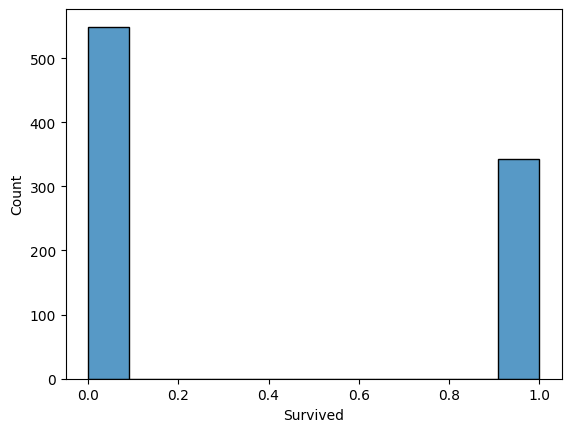

In [ ]:
sns.histplot(df['Survived'])
plt.show()

In [7]:
X = df.drop(['Survived'], axis=1)
y = df['Survived']


**Oversampling или undersampling для балансировки**

In [8]:
X, y = SMOTE().fit_resample(X, y) # оversampling
# X, y = TomekLinks().fit_resample(X, y) #undersampling

/Users/andreypovaliy/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


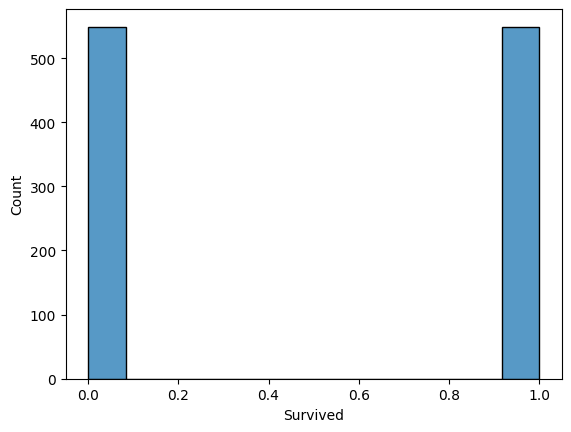

In [9]:
sns.histplot(y)
plt.show()

In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

**Включаем статификацию  `stratify` по таргет переменной `y`**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

## Алгоритм K-Nearest Neighbors (KNN) в классификации

KNN (k-ближайших соседей) – это простой и интуитивно понятный алгоритм машинного обучения, который не строит явной модели, а делает прогнозы, основываясь на сходстве объектов.

⸻

**Как работает KNN?**

	1.	Выбираем число соседей k.
	2.	Для нового объекта находим k ближайших точек из обучающей выборки (по расстоянию).
	3.	Определяем класс:
	    •	Мажоритарное голосование – объект получает класс, который встречается чаще среди k соседей.
	    •	Взвешенное голосование – соседи с меньшим расстоянием имеют больший вес.
	4.	Классифицируем новый объект.

**Когда использовать KNN?**

✅ Если данных немного.

✅ Если важна интерпретируемость (понятно, почему так классифицируется).


---
**❌ Минусы:**

❌ Медленный на больших данных (нужно хранить все примеры).

❌ Чувствителен к выборам k и шуму.

❌ Плохо работает с высокомерными данными (проклятие размерности).

**Обучим модель на кросс-валидации**

In [12]:
k_values = range(1,21)
mean_score = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=20, scoring='accuracy')
    mean_score.append(scores.mean())

best_k = k_values[np.argmax(mean_score)]
print(f'Best k={best_k} ; accuracy:{max(mean_score):.3f}')

Best k=7 ; accuracy:0.845


**Чтобы оценит стабильность модели построим boxplot**

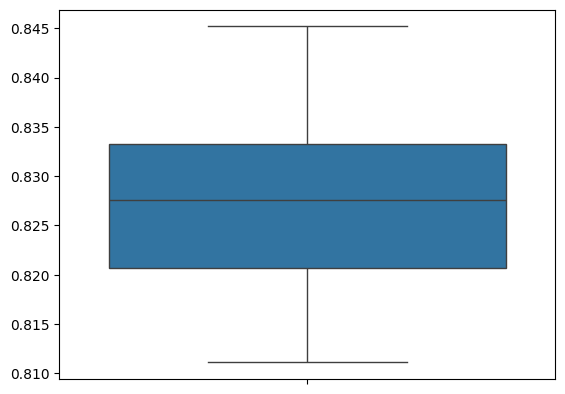

In [13]:
sns.boxplot(mean_score)
plt.show()

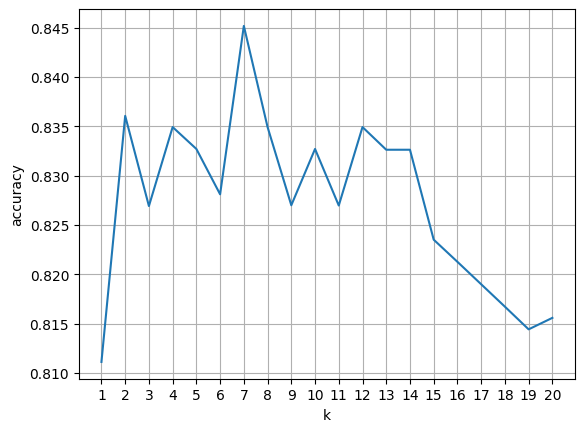

In [14]:
plt.plot(k_values, mean_score)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.xticks(k_values)
plt.grid()
plt.show()

**GridSearch Cross-Validation (поиск лучших параметров по сетке)**

In [15]:
knn = KNeighborsClassifier(n_neighbors=4)
# knn = KNeighborsClassifier()

# params = {
#     'n_neighbors': range(1,21),
#     'metric': ['euclidean', 'manhattan']
# }

# gs = GridSearchCV(knn, params, cv=20, scoring='accuracy')
# gs.fit(X_train, y_train)
# print(gs.best_params_)

knn.fit(X_train, y_train)
y_pred_train = knn.predict(X_train)
y_pred_test =  knn.predict(X_test)


# y_pred_train = gs.predict(X_train)
# y_pred_test =  gs.predict(X_test)



## Метрики бинарной классификации

Метрики, основанные на матрице ошибок (confusion matrix)

**Матрица ошибок состоит из:**

$TP(True Positive)$ – верно предсказанные положительные примеры

$TN (True Negative)$ – верно предсказанные отрицательные примеры

$FP (False Positive)$ – ложноположительные (ошибочно предсказанные как положительные)

$FN (False Negative)$ - ложноотрицательные (ошибочно предсказанные как отрицательные)

**Accuracy (Точность классификации)**

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

	•	Подходит, если классы сбалансированы
	•	Не подходит для несбалансированных данных

**Precision (Точность, позитивная предсказательная ценность)**

$$Precision = \frac{TP}{TP + FP}$$

	•	Доля верно предсказанных положительных примеров среди всех предсказанных как положительные
	•	Важна, если FP (ложные срабатывания) критичны (например, при диагностике рака)

**Recall (Полнота, чувствительность, TPR)**

$$Recall = \frac{TP}{TP + FN}$$

	•	Доля верно предсказанных положительных примеров среди всех фактических положительных
	•	Важна, если FN критичны (например, пропуск заболевания)

$F1-score$ (Среднее гармоническое $Precision$ и $Recall$)

$$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$

	•	Учитывает и Precision, и Recall
	•	Хороша для несбалансированных данных


Код:

In [ ]:
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)
precision_train = precision_score(y_train, y_pred_train)
precision_test = precision_score(y_test, y_pred_test)
recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred_test)

print(f'accuracy train: {accuracy_train:.3f}')
print(f'accuracy test: {accuracy_test:.3f}')
print(f'f1 train: {f1_train:.3f}')
print(f'f1 test: {f1_test:.3f}')
print(f'precision train: {precision_train:.3f}')
print(f'precision test: {precision_test:.3f}')
print(f'recall train: {recall_train:.3f}')
print(f'recall test: {recall_test:.3f}')

accuracy train: 0.884
accuracy test: 0.868
f1 train: 0.876
f1 test: 0.864
precision train: 0.940
precision test: 0.893
recall train: 0.820
recall test: 0.836


**Отчет классификации**

In [ ]:
report = classification_report(y_test, y_pred_test)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       110
           1       0.89      0.84      0.86       110

    accuracy                           0.87       220
   macro avg       0.87      0.87      0.87       220
weighted avg       0.87      0.87      0.87       220



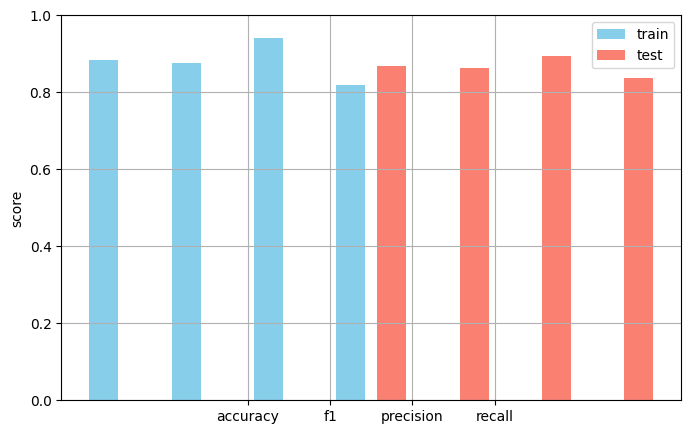

In [ ]:
metrics = ['accuracy', 'f1', 'precision', 'recall']
scores_train = [accuracy_train, f1_train, precision_train, recall_train]
scores_test = [accuracy_test, f1_test, precision_test, recall_test]

x = np.arange(len(metrics))

plt.figure(figsize=(8,5))
width = 0.35
plt.bar(x - width/0.2, scores_train, width=width, label='train', color='skyblue')
plt.bar(x + width/0.2, scores_test, width=width, label='test', color = 'salmon')

plt.xticks(x, metrics)
plt.ylabel('score')
plt.ylim(0,1)
plt.grid()
plt.legend()
plt.show()

**Визуализация матрицы ошибок**

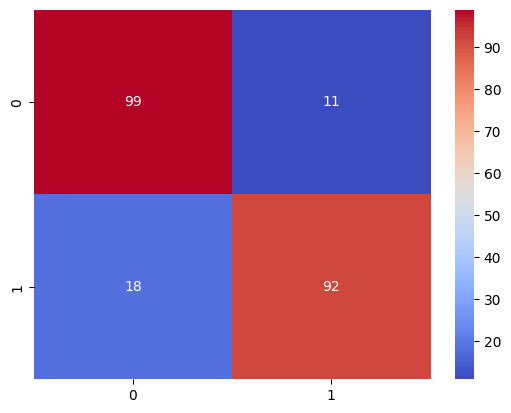

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, cmap='coolwarm')
plt.show()

# Логистическая регрессия

**Логистическая регрессия — это статистический метод, который используется для бинарной классификации, то есть когда нужно предсказать, относится ли объект к одному из двух классов (например, “да” или “нет”, “0” или “1”, “болен” или “здоров”).**


###📌 Основная идея:

Логистическая регрессия похожа на линейную регрессию, но вместо предсказания непрерывных значений (как, например, в предсказании цен на квартиры), она оценивает вероятность принадлежности к какому-то классу.

### Формула логистической регрессии:

$$P(Y = 1 | X) = \frac{1}{1 + e^{-(w_0 + w_1 X_1 + w_2 X_2 + … + w_n X_n)}}$$

🔹 $w_0, w_1, …, w_n$ — параметры модели (коэффициенты, которые мы подбираем во время обучения).

🔹 $X_1, X_2, …, X_n$ — входные признаки (фичи).

🔹 $\sigma(z) = \frac{1}{1 + e^{-z}}$ — сигмоидная (логистическая) функция, которая превращает любое число в диапазон $(0,1)$.



📊 Как она работает?

	1.	Линейная комбинация входных признаков вычисляется как линейная регрессия z
	2.	Применяется сигмоидная функция, чтобы преобразовать z  в вероятность от 0 до 1.
	3.	Пороговое значение: если вероятность выше 0.5, относим объект к классу 1, иначе — к классу 0.

In [ ]:
log_reg = LogisticRegression(penalty='l2', C=0.9, solver='saga', random_state = 1)
log_reg.fit(X_train, y_train)

y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)


accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)



In [ ]:
report_log_reg_train = classification_report(y_train, y_pred_train)
print(report_log_reg_train)

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       439
           1       0.81      0.79      0.80       439

    accuracy                           0.81       878
   macro avg       0.81      0.81      0.81       878
weighted avg       0.81      0.81      0.81       878



In [ ]:
report_log_reg_test = classification_report(y_test, y_pred_test)
print(report_log_reg_test)

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       110
           1       0.82      0.85      0.83       110

    accuracy                           0.83       220
   macro avg       0.83      0.83      0.83       220
weighted avg       0.83      0.83      0.83       220



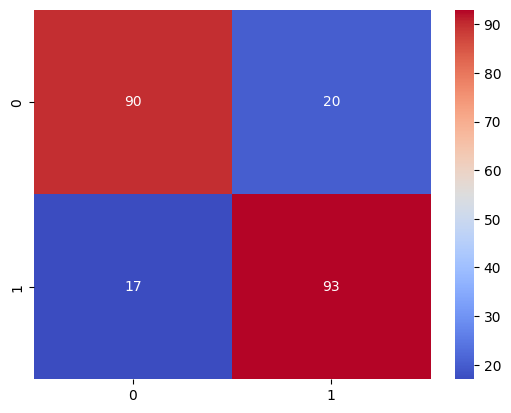

In [ ]:
cm_log_reg = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_log_reg, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# расчитанные вероятности 0 или 1 класса.
probabilities = log_reg.predict_proba(X_test)
print(probabilities)

[[0.1026342  0.8973658 ]
 [0.24348381 0.75651619]
 [0.86488165 0.13511835]
 [0.81423658 0.18576342]
 [0.24354599 0.75645401]
 [0.39319126 0.60680874]
 [0.84774603 0.15225397]
 [0.79473198 0.20526802]
 [0.85520049 0.14479951]
 [0.15435834 0.84564166]
 [0.11437116 0.88562884]
 [0.79447081 0.20552919]
 [0.99151959 0.00848041]
 [0.84981351 0.15018649]
 [0.02117061 0.97882939]
 [0.12830204 0.87169796]
 [0.5871624  0.4128376 ]
 [0.18177813 0.81822187]
 [0.24350566 0.75649434]
 [0.85510341 0.14489659]
 [0.7210594  0.2789406 ]
 [0.17002141 0.82997859]
 [0.77298147 0.22701853]
 [0.03861377 0.96138623]
 [0.03508705 0.96491295]
 [0.11034394 0.88965606]
 [0.75403186 0.24596814]
 [0.36288988 0.63711012]
 [0.40626443 0.59373557]
 [0.02172065 0.97827935]
 [0.85520049 0.14479951]
 [0.30176898 0.69823102]
 [0.86084949 0.13915051]
 [0.7948403  0.2051597 ]
 [0.91303846 0.08696154]
 [0.76292183 0.23707817]
 [0.75303932 0.24696068]
 [0.0171188  0.9828812 ]
 [0.90658757 0.09341243]
 [0.1798072  0.8201928 ]


In [ ]:
y_test

,Survived
902,1
28,1
267,1
288,1
47,1
...,...
137,0
465,0
549,1
91,0


In [ ]:
params = { 'penalty': ['l1', 'l2'],
           'C': [0.01, 0.1, 1, 10, 100],
           'solver': ['liblinear', 'saga']
}
gs = GridSearchCV(LogisticRegression(), params, cv=5, scoring='accuracy')
gs.fit(X_train, y_train)
print(gs.best_params_)
print(gs.best_score_)

{'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.8087272727272726


In [ ]:
log_reg_param = LogisticRegression(penalty='l1', C=10, solver='liblinear', random_state = 1)
log_reg_param.fit(X_train, y_train)

y_pred_train = log_reg_param.predict(X_train)
y_pred_test = log_reg_param.predict(X_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

In [ ]:
print(f'accuracy train: {accuracy_train:.3f}')
print(f'accuracy test: {accuracy_test:.3f}')

accuracy train: 0.805
accuracy test: 0.832


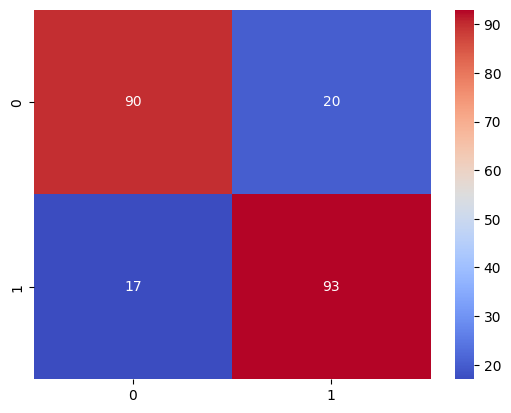

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, cmap='coolwarm')
plt.show()

# 🌳 Дерево принятия решений (Decision Tree)

Дерево решений — это алгоритм машинного обучения, который используется как для классификации, так и для регрессии. Он работает по принципу разбиения данных на основе условий, создавая структуру, похожую на дерево.

📌 Как работает алгоритм?

	1.	Выбирается лучший признак (фича), по которому можно разделить данные так, чтобы классы стали как можно более однородными.

	2.	Данные делятся на две или больше групп в зависимости от значения признака.

	3.	Процесс повторяется для каждой новой группы, пока:

	    •	Лист (конечный узел дерева) не станет достаточно чистым.

	    •	Глубина дерева не достигнет установленного предела.


🚀 Преимущества и недостатки

✅ Плюсы:

	•	Простая интерпретация: можно визуализировать.
	•	Может работать с категориальными и числовыми признаками.
	•	Не требует нормализации данных.

❌ Минусы:

	•	Склонен к переобучению (overfitting), особенно при глубоком дереве.
	•	Чувствителен к шуму в данных.
	•	Может давать неустойчивые результаты (изменение данных может сильно поменять дерево).



🛠 Критерии выбора признаков для разбиения

Чтобы определить, какой признак использовать для разделения, алгоритм использует меры неоднородности (чем ниже — тем лучше):

	•	Gini (индекс Джини) – измеряет вероятность неправильной классификации случайного примера.

$Gini = 1 - \sum p_i^2$
Чем меньше Gini, тем лучше разделение.

	•	Entropy (энтропия) – измеряет степень беспорядка в выборке.
$Entropy = - \sum p_i \log_2 p_i$
Чем меньше энтропия, тем лучше разделение.

**Код:**

In [ ]:
d_tree = DecisionTreeClassifier(max_depth=2, max_features=3, random_state=1)
d_tree.fit(X_train, y_train)

y_pred_train = d_tree.predict(X_train)
y_pred_test = d_tree.predict(X_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f'accuracy train: {accuracy_train:.3f}')
print(f'accuracy test: {accuracy_test:.3f}')

accuracy train: 0.800
accuracy test: 0.841


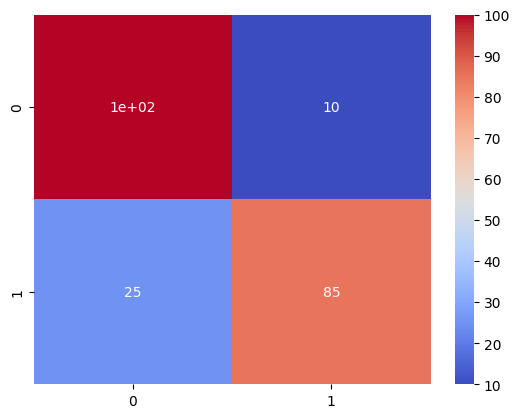

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, cmap='coolwarm')
plt.show()

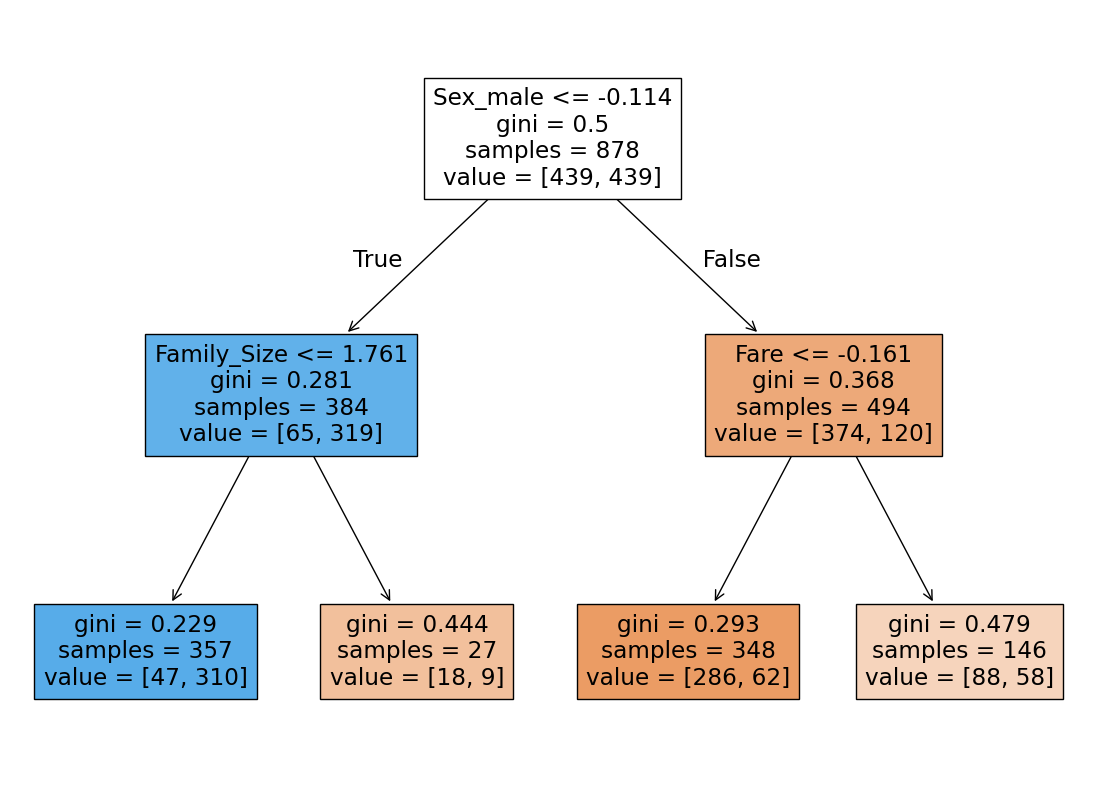

In [ ]:
plt.figure(figsize=(14, 10))
plot_tree(d_tree, filled=True, feature_names=features)
plt.show()